# Testing state abstraction of Ott's data

While we aim to collect a whole new data set for this project, we can nontheless test whether our state abstraction model of existing data. The design we aim to use is adapted Ott et al.'s design. For our purpose, we will increase the number of states compared to the original, to make it more difficult for participants to solve the MDP to push them to resort to abstraction. Therefore, the original design is not necessarily geared toward state abstraction. Nonetheless, participants were observed to behave suboptimally in the original design, which might indicate that already the state space size of the original study might be too large for participants to deal with. We can therefore test our state abstraction model on these data. First, we will compute the pairwise distances of each states in the original state space, generate abstracted MDP at various $\epsilon$ levels ($\epsilon=[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]$) and compare the results of that model to the model from Ott et al.

## Compute pairwise distances:

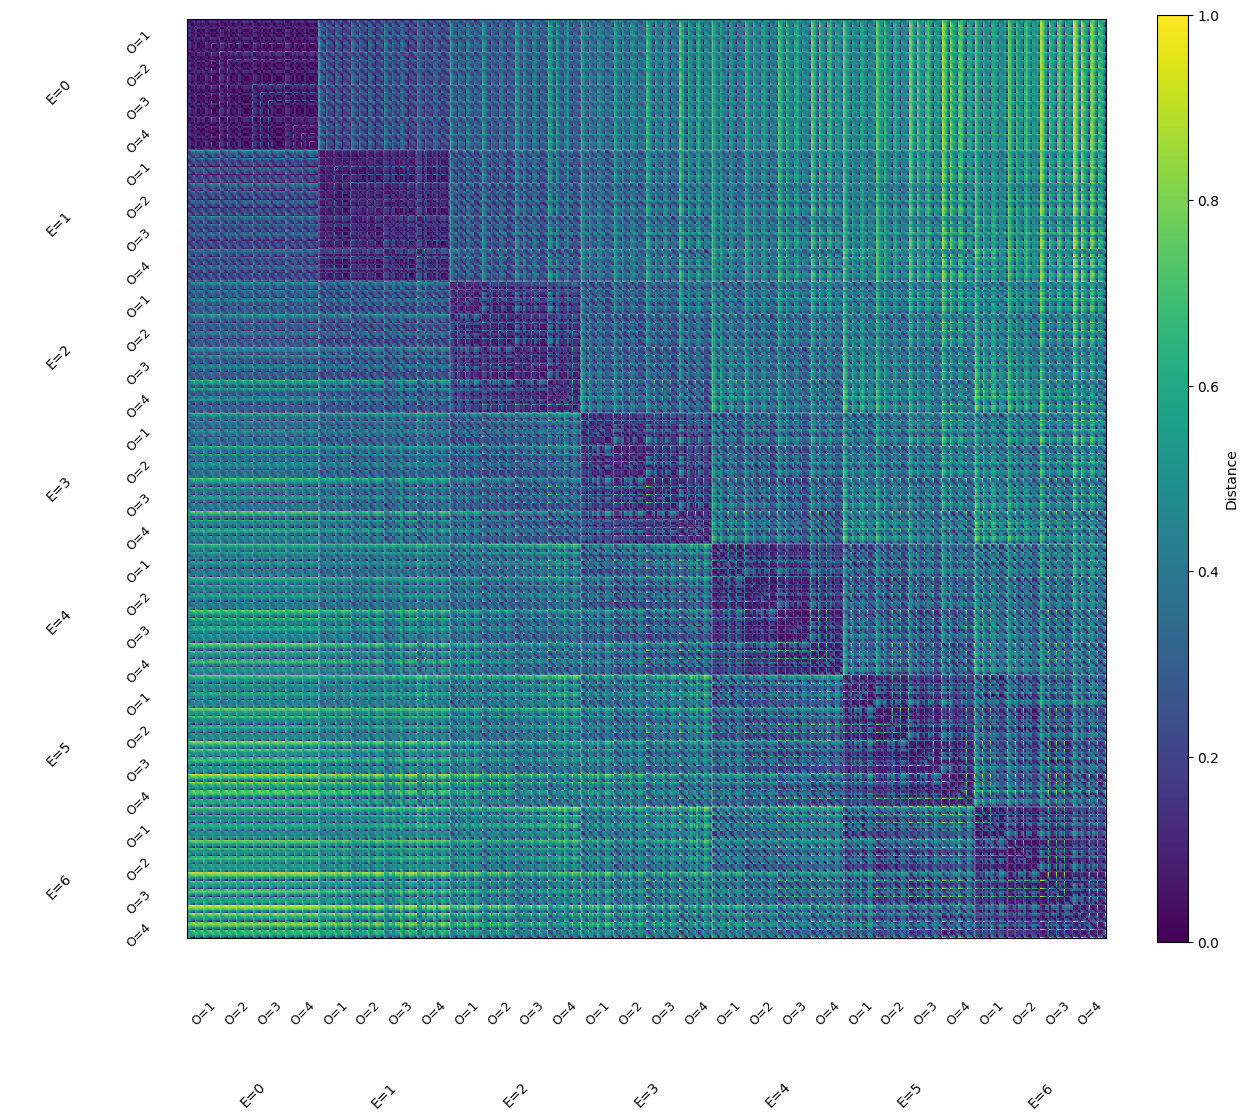

In [75]:
import numpy as np
import pandas as pd
import os
from utils import bisim_metric, plot_state_matrix
from scipy.special import expit
from MarkovDecisionProcess import MDP
from TaskConfig import LimitedEnergyTask
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from utils import state_classes_from_lbl, avg_reduce_mdp, reduced2full_value
import pymc as pm
import arviz as az
import seaborn as sns


# Create the task and its parameters (transition probability, reward...):

task = LimitedEnergyTask(O=[1, 2, 3, 4], p_offer=[1/4] * 4)
task.build()

# Create full MDP and compute solution for later reference:
task_mdp = MDP(task.states, task.tp, task.r, s2i=task.s2i)
V_full, Q_full = task_mdp.backward_induction()
R_full = task_mdp.expected_return(task_mdp.greedy_policy(Q_full), initial_energy=3)

# Compute pairwise distances:
if not os.path.isfile('distance_matrix_ott.npy'):
    distances_matrix = bisim_metric(task.tp, task.r, gamma=0.9, tol=1e-9, njobs=-1, max_iters=1000)
    distances_matrix = distances_matrix / np.max(distances_matrix)
    np.save('distance_matrix_ott.npy', distances_matrix)
else:
    distances_matrix = np.load('distance_matrix_ott.npy')

# Plot the distance matrix:
plot_state_matrix(distances_matrix, task.states, feature_names=["E", "O", "CC", "FC", "T"], depth=2)
plt.show()

# Compute decision values for each abstraction level:

In [76]:
abstraction_levels = np.arange(0, 0.1, 0.01)
DVs = {f'eps: {eps:.3f}': None for eps in abstraction_levels}
for eps in abstraction_levels:
    # Abstraction of 0 = no abstraction
    if eps == 0:
        DVs[f'eps: {eps:.3f}'] = Q_full[:, 1] - Q_full[:, 0]
    else:
        # Find states clusters
        states_lbl = AgglomerativeClustering(distance_threshold=eps, 
                                            n_clusters=None, linkage='complete', metric='precomputed').fit(distances_matrix).labels_
        # Create state classes:
        state_classes = state_classes_from_lbl(task.states, states_lbl)
        # Reduce the MDP accordingly:
        statesR, tpR, rR, class_of_state = avg_reduce_mdp(state_classes, task_mdp.tp, task_mdp.r, task_mdp.s2i)
        # Create reduced MDP:
        task_mdp_reduced = MDP(statesR, tpR, rR)
        # Solve the MDP:
        V_R, Q_R = task_mdp_reduced.backward_induction()
        # Project back to full space:
        V_from_reduced, Q_from_reduced = reduced2full_value(class_of_state, V_R, Q_R)
        # Add to decision values
        DVs[f'eps: {eps:.3f}'] = Q_from_reduced[:, 1] - Q_from_reduced[:, 0]

## Prepare data for model fitting:

C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_32220\2962632344.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if i > 10 and row[0] == 0:
C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_32220\2962632344.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('Set3')


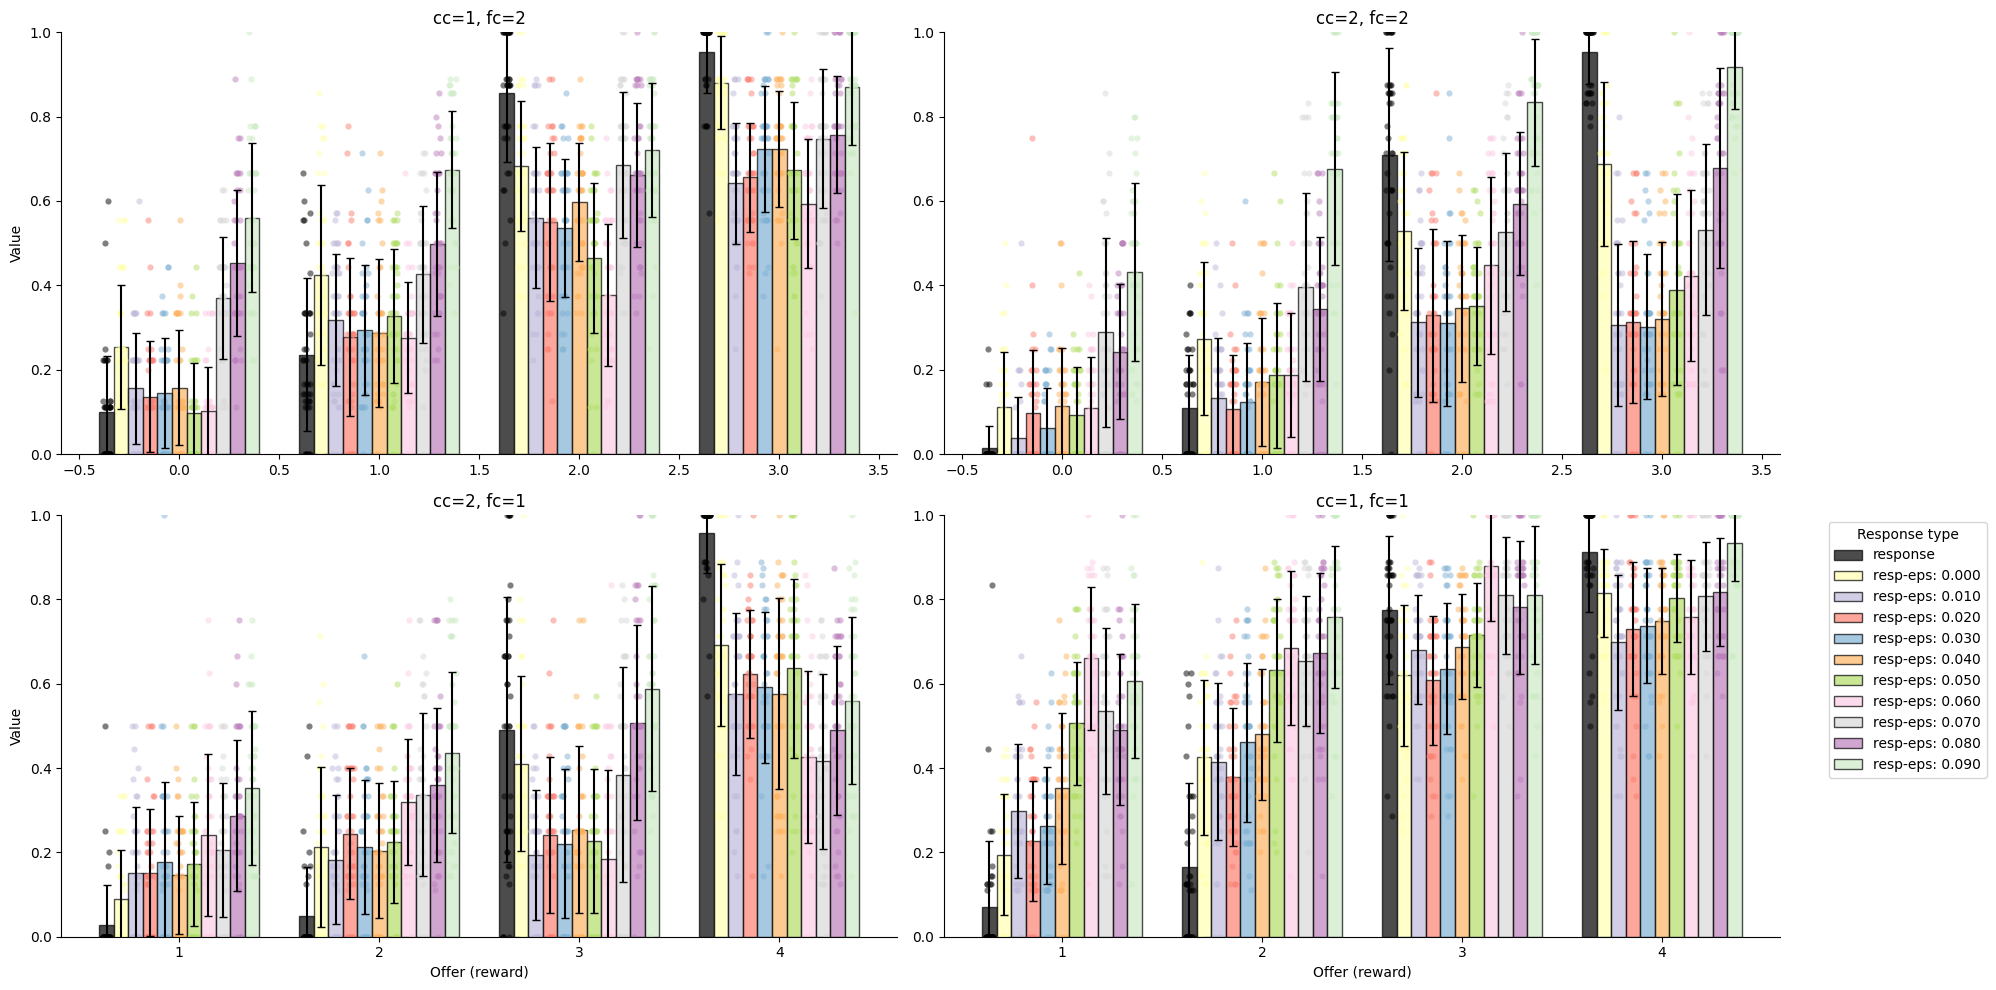

In [77]:
# Download data from Florian's repo:
url = 'https://github.com/fmott/context_dependent_planning/blob/1.2/data/behaviour/data_all_participants_training_20220215120300.csv?raw=true'
data = pd.read_csv(url, on_bad_lines='skip')
# Remove nans:
data = data.dropna()
# Flip responses: 1 = accept:
data["response"] = np.abs(data["response"] - 1)
# Remove trials with max energy or too low energy:
data = data[data["energy"] != 6].reset_index(drop=True)
data = data[data["energy"] >= data["energy_cost"]].reset_index(drop=True)
# Add a subject column:
sub_id = 1
for i, row in data.iterrows():
    if i > 10 and row[0] == 0:
        sub_id += 1
    data.at[i, 'subject'] = f'sub-{sub_id}'
# Remove the 
# Get subject IDs:
subj_idx_raw, subj_labels = pd.factorize(data["subject"])
coords = {
    "observation": np.arange(len(data)),
    "subject": subj_labels,
}

transitions_costs = {
    0: [1, 1],
    1: [2, 1],
    2: [1, 2],
    3: [2, 2]
}
# Add the decision value associated with each epsilons:
for eps in abstraction_levels:
    # Get the decision value:
    dv = DVs[f'eps: {eps:.3f}']
    # Loop through each trial to set DV:
    dv_trials = []
    mdl_sim_resps = []
    decision_match = []
    for trial_i, trial in data.iterrows():
        e, o, cc, t = trial.energy, trial.reward, trial.energy_cost, trial.trial
        fc = transitions_costs[trial.transition][1]
        dv_trials.append(dv[task.s2i[(e, o, cc, fc, t+1)]])
        # Simulate data according to that plan:
        mdl_sim_resps.append(np.random.binomial(1, expit(dv[task.s2i[(e, o, cc, fc, t+1)]])))
        decision_match.append(1 - np.abs(trial.response - mdl_sim_resps[-1]))
    data[f'DV-eps: {eps:.3f}'] = dv_trials
    data[f'resp-eps: {eps:.3f}'] = mdl_sim_resps
    data[f'decision_match-eps: {eps:.3f}'] = decision_match

# Plot the results:
fig, ax = plt.subplots(2, 2, figsize=[20, 10])
import matplotlib
cmap = matplotlib.cm.get_cmap('Set3')
ax = ax.flatten()
for i, trans in enumerate(data['transition'].unique()):
    results = data[data['transition'] == trans].groupby(['subject', 'reward'])[['response', *[f'resp-eps: {eps:.3f}' for eps in abstraction_levels]]].mean().reset_index()
    resp_cols = [c for c in results.columns if c.startswith('resp-eps') or c == 'response']
    rewards = np.sort(results['reward'].unique())

    n_rewards = len(rewards)
    n_resp = len(resp_cols)

    x = np.arange(n_rewards)  # base positions per reward/offer
    bar_width = 0.8 / n_resp  # so each group takes ~0.8 width

    # precompute stats
    grouped = results.groupby('reward')[resp_cols]

    means = grouped.mean()
    stds = grouped.std()

    for j, col in enumerate(resp_cols):
        # horizontal offset for this response-type within each reward group
        offset = (j - (n_resp - 1) / 2) * bar_width
        
        # bar positions
        x_pos = x + offset
        
        # get mean and std aligned with rewards
        m = means[col].reindex(rewards).values
        s = stds[col].reindex(rewards).values

        # bars: mean + std
        if col == 'response':
            color = 'k'
        else:
            color = cmap(j)
        try:
            ax[i].bar(
                x_pos,
                m,
                bar_width,
                yerr=s,
                capsize=3,
                alpha=0.7,
                label=col,
                color=color,
                edgecolor='k',
                linewidth=1
            )
        except:
            print('A')

        # overlay per-subject "cloud" for this response-type
        for ii, r in enumerate(rewards):
            vals = results.loc[results['reward'] == r, col].values
            # jitter around the bar center
            jitter = np.random.uniform(-bar_width / 4, bar_width / 4, size=len(vals))
            ax[i].scatter(
                np.full_like(vals, x_pos[ii]) + jitter,
                vals,
                color=color,
                s=20,
                alpha=0.5,
                edgecolors='k',
                linewidths=0.0
            )

    # cosmetic stuff
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].set_ylim([0, 1])
    if i > 1:
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(rewards)
        ax[i].set_xlabel('Offer (reward)')
    if i == 0 or i == 2:
        ax[i].set_ylabel('Value')
    ax[i].set_title(f'cc={transitions_costs[trans][0]}, fc={transitions_costs[trans][1]}')
    if i == len(ax) -1:
        ax[i].legend(title='Response type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_32220\2879059810.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('Set3')


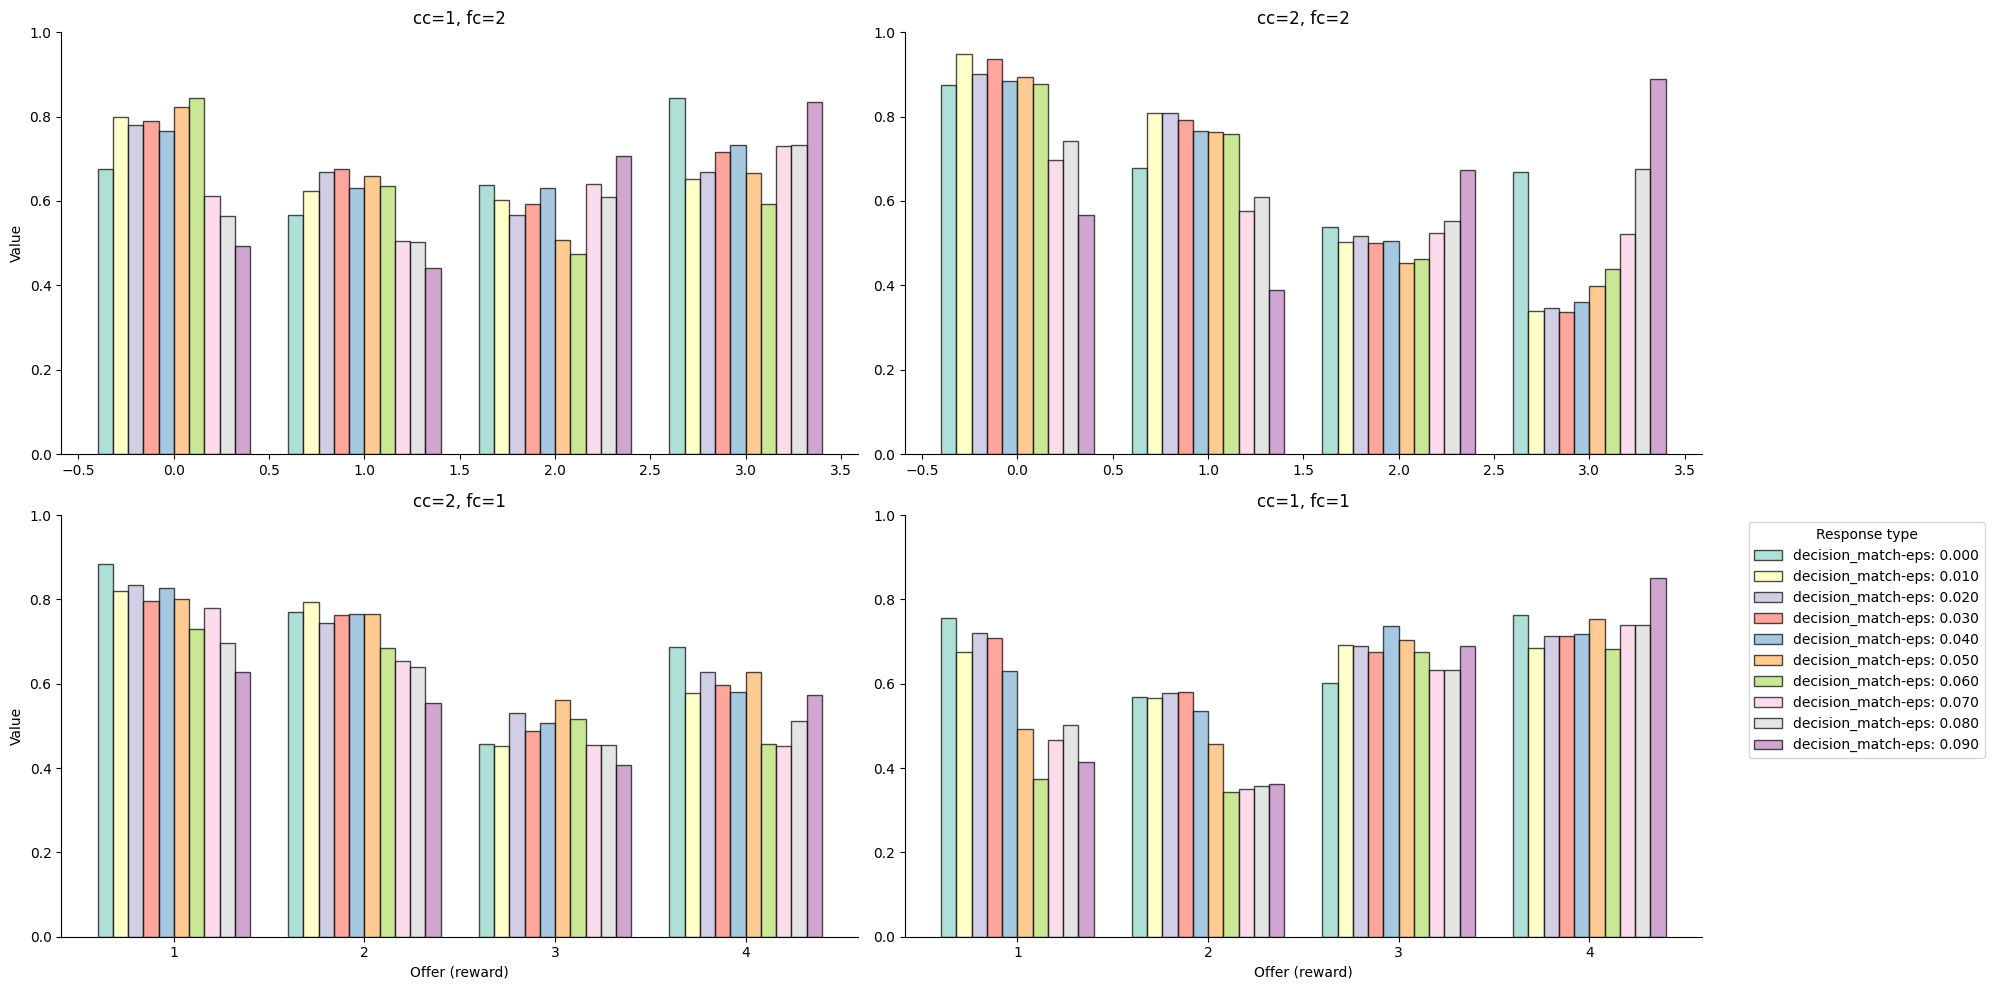

In [78]:
# Plot the difference between each models prediction and participants behaviour:
# Plot the results:
fig, ax = plt.subplots(2, 2, figsize=[20, 10])
import matplotlib
cmap = matplotlib.cm.get_cmap('Set3')
ax = ax.flatten()
for i, trans in enumerate(data['transition'].unique()):
    results = data[data['transition'] == trans].groupby(['subject', 'reward'])[[f'decision_match-eps: {eps:.3f}' for eps in abstraction_levels]].mean().reset_index()
    resp_cols = [c for c in results.columns if c.startswith('decision_match')]
    rewards = np.sort(results['reward'].unique())

    n_rewards = len(rewards)
    n_resp = len(resp_cols)

    x = np.arange(n_rewards)  # base positions per reward/offer
    bar_width = 0.8 / n_resp  # so each group takes ~0.8 width

    # precompute stats
    grouped = results.groupby('reward')[resp_cols]

    means = grouped.mean()
    stds = grouped.std()

    for j, col in enumerate(resp_cols):
        # horizontal offset for this response-type within each reward group
        offset = (j - (n_resp - 1) / 2) * bar_width
        
        # bar positions
        x_pos = x + offset
        
        # get mean and std aligned with rewards
        m = means[col].reindex(rewards).values
        s = stds[col].reindex(rewards).values

        # bars: mean + std
        if col == 'response':
            color = 'k'
        else:
            color = cmap(j)
        ax[i].bar(
            x_pos,
            m,
            bar_width,
            capsize=3,
            alpha=0.7,
            label=col,
            color=color,
            edgecolor='k',
            linewidth=1
        )

    # cosmetic stuff
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].set_ylim([0, 1])
    if i > 1:
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(rewards)
        ax[i].set_xlabel('Offer (reward)')
    if i == 0 or i == 2:
        ax[i].set_ylabel('Value')
    ax[i].set_title(f'cc={transitions_costs[trans][0]}, fc={transitions_costs[trans][1]}')
    if i == len(ax) -1:
        ax[i].legend(title='Response type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()